In [11]:
import pandas as pd
import geopandas as gpd
import seaborn as sns

In [41]:
gcs_mount_path = '../../../gcs'

In [2]:
count_data = pd.read_csv(f'{gcs_mount_path}/count_file/Final_data_feb8.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
segment_geos = gpd.read_file(f'{gcs_mount_path}/count_file/Revised_Estimated_SC_ATT_Feb9.geojson')

In [48]:
places = gpd.read_file(f'{gcs_mount_path}/context_data/census/tl_2021_06_place')

counties = gpd.read_file(f'{gcs_mount_path}/context_data/census/tl_2021_us_county')

In [51]:
counties = counties.query("STATEFP == '06'")

In [23]:
count_data = count_data.join(segment_geos.set_index(['matched_se', 'year'])[['geometry']],
                on=['matched_seg_id', 'year'])

count_data = count_data.drop(columns=['Unnamed: 0'])

In [29]:
count_data = gpd.GeoDataFrame(count_data)

In [53]:
places = places.to_crs(count_data.crs)
counties = counties.to_crs(count_data.crs)

# Traffic data exploration
Let's start with an exploration of our imputed bike traffic volumes. First I'm going to switch this to a more standard AADT.

In [32]:
count_data['aadt'] = count_data['ATT']/365.

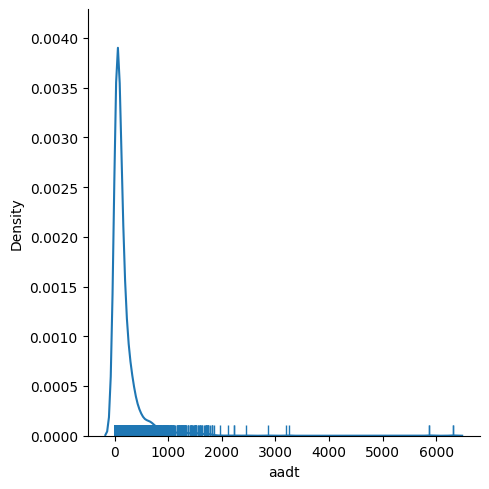

In [33]:
sns.displot(count_data['aadt'], kind='kde', rug=True)

Some of these seem erroneous - especially those over 5000/day. Let's check out a map of those over 2000/day.

In [40]:
count_data.sort_values('aadt', ascending=False)

,Unnamed: 0,index,year,Leg,matched_seg_id,Lat,Long,ATT,ATT in Million,segment_id,...,rt_lanes_amt,lt_lanes_amt,rt_trav_way_width,rt_i_shd_tot_width,rt_o_shd_tot_width,lt_trav_way_width,lt_i_shd_tot_width,lt_o_shd_tot_width,geometry,aadt
1113,1113,811,2015,N,64850,33.987501,-118.472123,2303203,2.303203,26668.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (918350.144 3770044.310, 918359.484...",6310.145205
1112,1112,810,2015,N,64682,33.982118,-118.467676,2303203,2.303203,26511.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (918606.626 3769700.310, 918628.730...",6310.145205
1335,1335,1002,2015,S,64854,33.987236,-118.471897,2144205,2.144205,26672.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (918381.607 3770001.635, 918393.804...",5874.534247
1334,1334,1001,2015,S,64618,33.979071,-118.465131,2144205,2.144205,26445.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (919001.782 3769188.613, 919023.431...",5874.534247
2628,2628,2244,2016,S,135675,38.545529,-121.747601,1186858,1.186858,88712.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (609157.155 4267012.678, 609125.742...",3251.665753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,3626,3927,2018,S,157125,37.771683,-122.236562,0,0.000000,67782.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (567197.970 4180700.164, 567213.960...",0.000000
3631,3631,3089,2017,S,157378,37.792894,-122.227165,0,0.000000,44621.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (568003.627 4183043.585, 568083.902...",0.000000
3632,3632,3933,2018,S,157378,37.792894,-122.227165,0,0.000000,44621.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (568003.627 4183043.585, 568083.902...",0.000000
3455,3455,2971,2017,N,157542,37.766358,-122.222778,0,0.000000,68158.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (568368.549 4180091.538, 568383.540...",0.000000


In [38]:
count_data.query("aadt > 2000")[['aadt', 'geometry']].explore('aadt')